# Identify Alleles with Cell Count Differences

In [2]:
# Imports
import os
import numpy as np
import polars as pl
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel

PLATEMAP_DIR = "../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles"
LOG_DIR = "../../../8.2_updated_snakemake_pipeline/outputs/classification_results"

bio_rep_batches = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]

## 1. Summarize Cell Count Profiles

### 1.1 Allele Metadata

In [3]:
batch_id = bio_rep_batches[0]
allele_meta_df = pl.DataFrame()

for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
    platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
    allele_meta_df = pl.concat([allele_meta_df, platemap_df], how="diagonal_relaxed")

allele_meta_df

plate_map_name,well_position,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter
str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str
"""B13A7A8P1_R1""","""A01""","""ABCD1""","""ABCD1""","""A01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""disease_wt""",1.00008637e8,null,null,null,7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,1,1,1,"""A"""
"""B13A7A8P1_R1""","""C01""","""ABCD1""","""ABCD1_Arg518Trp""","""C01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007022""","""1552C>T""","""Arg518Trp""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,2,3,1,"""C"""
"""B13A7A8P1_R1""","""E01""","""ABCD1""","""ABCD1_Arg389Gly""","""E01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007023""","""1165C>G""","""Arg389Gly""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,3,5,1,"""E"""
"""B13A7A8P1_R1""","""G01""","""ABCD1""","""ABCD1_Arg518Gln""","""G01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",1.00008637e8,"""CCSBVarC007021""","""1553G>A""","""Arg518Gln""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,4,7,1,"""G"""
"""B13A7A8P1_R1""","""I01""","""BAP1""","""BAP1""","""I01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""disease_wt""",3760.0,null,null,null,7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,1,5,9,1,"""I"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B13A7A8P2_R1""","""L12""",null,null,"""L12""","""B13A7A8P2_R1""","""B14A7A8P2_R2""",null,null,null,null,null,7.0,2.0,13.0,14.0,null,null,null,null,null,null,2,4,6,6,12,12,"""L"""
"""B13A7A8P2_R1""","""L14""","""MAPK9""","""MAPK9""","""L14""","""B13A7A8P2_R1""","""B14A7A8P2_R2""","""NC""",null,null,null,null,7.0,2.0,13.0,14.0,null,null,null,null,527.0,null,2,4,7,6,12,14,"""L"""
"""B13A7A8P2_R1""","""J16""","""RHEB""","""RHEB""","""J16""","""B13A7A8P2_R1""","""B14A7A8P2_R2""","""NC""",null,null,null,null,7.0,2.0,13.0,14.0,null,null,null,null,527.0,null,2,4,8,5,10,16,"""J"""


In [4]:
allele_meta_df.filter(pl.col("node_type")=="allele")["gene_allele"].unique()

gene_allele
str
"""F9_Ala233Thr"""
"""CCM2_Glu366Lys"""
"""CCM2_Tyr261Asp"""
"""SDHD_Gly138Val"""
"""CCM2_Ser60Arg"""
…
"""CCM2_Thr394Ser"""
"""LMNA_Arg335Trp"""
"""NF2_Arg335Cys"""


In [5]:
combined_profiles = pl.DataFrame()
for batch_id in bio_rep_batches:
    # Get meta features
    batch_alleles = (
        pl.scan_parquet(
            f"{PROF_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
        )
        .select([
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
        ])
    )
    combined_profiles = pl.concat([combined_profiles, batch_alleles.collect()])

## Get the cell count per allele in each well
well_profiles = combined_profiles.group_by([
    "Metadata_Well", "Metadata_Plate", "Metadata_gene_allele"
]).len().rename({"len": "Cell_count"})

In [6]:
batch_log_files = [
    f"{LOG_DIR}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/classify.log" \
    for batch_id in bio_rep_batches
]

dropped_well_df = pl.DataFrame()
for logfile in batch_log_files:
    with open(logfile, encoding="latin-1") as f:
        lines = f.readlines()
    dropped_wells = [(l.split(",")[0].strip(), l.split(",")[1].strip()) for l in lines if l.startswith("2025")]
    dropped_well_df = pl.concat([dropped_well_df, 
                                 pl.DataFrame({"plate": [well[0] for well in dropped_wells],
                                               "imaging_well": [well[1].split(":")[0] for well in dropped_wells],
                                               "gene_allele": [well[1].split(":")[1] for well in dropped_wells]})])

In [7]:
dropped_well_df.unique(subset="gene_allele")["gene_allele"]

gene_allele
str
"""RAD51D_Phe305Leu"""
"""BRAF_Phe595Leu"""
"""SHOC2_Thr205Ala"""
"""MSH2_His46Gln"""
"""MSH2_Leu187Arg"""
…
"""PRKACB"""
"""G6PD_Arg120His"""
"""ZC4H2_Cys192Tyr"""


## 2. Cell Count Differences

In [9]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import pandas as pd


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge
    

def paired_ttest(dat, reference: str, var: str):
    ## perform stat test
    ## sorted the two alleles to make sure they are from the same plate for paired t-test
    dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    
    if (dat[dat["Metadata_gene_allele"]==reference].shape[0] != dat[dat["Metadata_gene_allele"]==var].shape[0]):
        # pivot to wide: one row per plate
        wide = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values="Cell_count")
        # drop any plate that doesn’t have both measurements
        wide = wide.dropna(subset=[reference,var])
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide[reference], wide[var])
    else:
        assert(all(dat[dat["Metadata_gene_allele"]==reference]["Metadata_Plate"].values== \
                dat[dat["Metadata_gene_allele"]==var]["Metadata_Plate"].values))
        t_stat, p_val = ttest_rel(dat[dat["Metadata_gene_allele"]==reference]["Cell_count"].values, 
                                dat[dat["Metadata_gene_allele"]==var]["Cell_count"].values)

    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

### 2.1 Paired T-test

In [10]:
well_cc_stats = []
for allele in well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique():
    if allele is None or allele.split("_")[0] == allele:
        continue

    reference = allele.split("_")[0]
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    )

    if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
        # print(f"{allele}: missing reference/variant.")
        continue

    temp_prof = temp_prof.to_pandas().dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    ref_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==reference]
    var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]

    ## Select ONLY the wells most distant from the edge per each allele to minimize the well-position edge effects
    ## deprecated: let's compare every pair
    # if (ref_profiles.shape[0] > var_profiles.shape[0]):
    #     ref_al_wells = ref_profiles["Metadata_Well"].unique()
    #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
    #     # Sort wells by max distance from edges (descending)
    #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
    #     ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        
    # if (ref_profiles.shape[0] < var_profiles.shape[0]):
    #     ref_al_wells = var_profiles["Metadata_Well"].unique()
    #     well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
    #     # Sort wells by max distance from edges (descending)
    #     most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
    #     var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

    ref_wells = ref_profiles["Metadata_Well"].unique()
    var_wells = var_profiles["Metadata_Well"].unique()
    ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    for ref_var in ref_var_pairs:
        df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)]
        try:
            # display(temp_prof)
            paired_t_res = paired_ttest(
                dat=df_sampled,
                reference=reference,
                var=allele
            )
            paired_t_res = paired_t_res.with_columns(
                pl.lit(ref_var[0]).alias("Ref_well"),
                pl.lit(ref_var[1]).alias("Var_well")
            )
            well_cc_stats.append(
                paired_t_res
            )
        except:
            well_cc_stats.append(
                pl.DataFrame(
                    {
                        "t_stat": np.nan,
                        "p_val": np.nan,
                        "Gene": reference,
                        "Variant": allele,
                        "Ref_well": ref_var[0],
                        "Var_well": ref_var[1],
                    }
                )
            )
            continue
        

well_cc_stats = pl.concat(well_cc_stats,  how="vertical")
# well_cc_stats = well_cc_stats.rename({"t_stat": "U2OS_t"})
# well_cc_stats = well_cc_stats.select(["Gene", "Variant", "U2OS_t", "p_val", "Ref_well", "Var_well"])

In [11]:
well_cc_stats = []
for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele:
        continue

    reference = allele.split("_")[0]
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    )

    temp_prof = temp_prof.to_pandas().dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    temp_prof["dist2edge"] = temp_prof["Metadata_Well"].apply(lambda x: compute_distance(well_to_coordinates(x)[1], well_to_coordinates(x)[2]))

    var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
    ref_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==reference]
    
    # # print(temp_prof)
    # # diff = temp_prof[temp_prof["Metadata_gene_allele"]==allele]["Cells_Intensity_IntegratedIntensityEdge_GFP"].values - \
    # #        temp_prof[temp_prof["Metadata_gene_allele"]==reference]["Cells_Intensity_IntegratedIntensityEdge_GFP"].values

    # try:
    if (ref_profiles.shape[0] > var_profiles.shape[0]):
        ref_al_wells = ref_profiles["Metadata_Well"].unique()
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        # Sort wells by max distance from edges (descending)
        most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        
    if (ref_profiles.shape[0] < var_profiles.shape[0]):
        ref_al_wells = var_profiles["Metadata_Well"].unique()
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        # Sort wells by max distance from edges (descending)
        most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

    temp_prof = pd.concat([ref_profiles, var_profiles])
    # display(temp_prof)

    # fit Cell_count ~ dist2edge
    m0 = smf.ols("Cell_count ~ dist2edge", data=temp_prof).fit()
    temp_prof["resid"] = m0.resid

    # pivot to wide form
    wide = temp_prof.pivot(index="Metadata_Plate",
                           columns="Metadata_gene_allele",
                           values="resid")
    try:
        t, p = ttest_rel(wide[allele], wide[reference])
        print(f"paired t on residuals: t={t:.3f}, p={p:.3f}")
        summary_df = pl.DataFrame(
            {
                "t_stat": t,
                "p_val": p
            }
        )
        summary_df = summary_df.with_columns(
            pl.lit(reference).alias("Gene"), pl.lit(allele).alias("Variant")
        )

        well_cc_stats.append(summary_df)
    except:
        continue

  2%|▏         | 13/626 [00:00<00:06, 88.11it/s]

paired t on residuals: t=0.000, p=1.000
paired t on residuals: t=0.930, p=0.383
paired t on residuals: t=0.000, p=1.000
paired t on residuals: t=-0.000, p=1.000
paired t on residuals: t=0.317, p=0.761
paired t on residuals: t=0.000, p=1.000
paired t on residuals: t=2.214, p=0.062
paired t on residuals: t=nan, p=nan
paired t on residuals: t=0.000, p=1.000
paired t on residuals: t=1.588, p=0.156
paired t on residuals: t=0.000, p=1.000
paired t on residuals: t=0.000, p=1.000


ValueError: Index contains duplicate entries, cannot reshape

In [12]:
pl.concat(well_cc_stats)

t_stat,p_val,Gene,Variant
f64,f64,str,str
9.0560e-15,1.0,"""CCM2""","""CCM2_Cys170Tyr"""
0.930372,0.383143,"""CCM2""","""CCM2_Thr222Met"""
3.6757e-15,1.0,"""CCM2""","""CCM2_Ser143Phe"""
-1.4196e-14,1.0,"""RHO""","""RHO_Arg135Trp"""
0.316765,0.76066,"""CCM2""","""CCM2_Asp419Tyr"""
…,…,…,…
NaN,NaN,"""BRCA1""","""BRCA1_Tyr179Cys"""
2.8992e-15,1.0,"""SHOC2""","""SHOC2_Ser57Phe"""
1.588058,0.156296,"""CCM2""","""CCM2_Thr296Ala"""


In [ ]:
# well_cc_stats.write_csv(f"../../outputs/2025_01_Batch_13-14/well-level_cell-count_changes.csv")

## Previous approach

In [43]:
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

# Alleles must be mislocalized in both batches
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("Mislocalized")
).unique()

local_wtvar = local_wtvar.pivot(
    index=["allele_0"], ## , "Allele_set"
    on="Batch",
    values="Mislocalized",
).with_columns(
    ((pl.col("batch13") == 1) & (pl.col("batch14") == 1)).alias(
        "Mislocalized_both_batches"
    )
)

misloc_alleles = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .select("allele_0")
    .to_series()
    .to_list()
)

misloc_wt = (
    local_wtvar
    # .filter(pl.col("Mislocalized_both_batches"))
    .with_columns(pl.col("allele_0").str.replace("_.*", "").alias("wt"))
    .select("wt")
    .to_series()
    .unique()
    .to_list()
)

all_alleles = misloc_alleles + misloc_wt

# misloc_alleles

In [47]:
# Get individual classifiers
ind_class = metrics_df.filter(
    (pl.col("Metadata_Control")!="True")
    & (
        pl.col("allele_0").is_in(misloc_alleles)
        & (pl.col("Full_Classifier_ID").str.contains("true"))
    )
)
ind_class

AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,str,f64,f64,f64,f64
0.477336,0.316587,0.477766,0.482755,0.316583,0.648855,0.482719,"""2025_01_27_B13A7A8P1_T4_K03_I0…","""2025_01_27_B13A7A8P1_T4_K03_I0…","""2025_01_27_B13A7A8P1_T4""",1536,393,"""K03""","""BAP1_Glu31Lys""",1440,199,"""I01""","""BAP1""","""False""",0.483871,0.336149,1.066667,1.974874
0.673248,0.61258,0.69292,0.622429,0.4375,0.807786,0.622643,"""2025_01_28_B14A7A8P2_T4_C17_O1…","""2025_01_28_B14A7A8P2_T4_C17_O1…","""2025_01_28_B14A7A8P2_T4""",1010,411,"""C17""","""RET_Gly321Arg""",755,288,"""O13""","""RET""","""False""",0.427762,0.412017,1.337748,1.427083
0.962789,0.983231,0.962044,0.889414,0.953125,0.807229,0.880177,"""2025_01_27_B13A7A8P1_T4_O10_G0…","""2025_01_27_B13A7A8P1_T4_O10_G0…","""2025_01_27_B13A7A8P1_T4""",299,83,"""O10""","""F9_Trp453Arg""",818,192,"""G06""","""F9""","""False""",0.732319,0.698182,2.735786,2.313253
0.694184,0.603266,0.685197,0.627003,0.551122,0.702091,0.626606,"""2025_01_27_B13A7A8P1_T4_P24_F2…","""2025_01_27_B13A7A8P1_T4_P24_F2…","""2025_01_27_B13A7A8P1_T4""",1253,574,"""P24""","""RAD51D_Val66Leu""",911,401,"""F24""","""RAD51D""","""False""",0.42098,0.411282,1.375412,1.431421
0.682807,0.725885,0.663799,0.609251,0.846348,0.385135,0.615741,"""2025_01_28_B14A7A8P1_T3_I24_B0…","""2025_01_28_B14A7A8P1_T3_I24_B0…","""2025_01_28_B14A7A8P1_T3""",704,296,"""I24""","""FARS2_Arg419Cys""",1204,397,"""B01""","""FARS2""","""False""",0.631027,0.572872,1.710227,1.341216
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.884153,0.842909,0.891481,0.792055,0.732558,0.848101,0.79033,"""2025_01_28_B14A7A8P1_T2_A07_I0…","""2025_01_28_B14A7A8P1_T2_A07_I0…","""2025_01_28_B14A7A8P1_T2""",1557,395,"""A07""","""BRAF_Val471Phe""",744,258,"""I05""","""BRAF""","""False""",0.323338,0.3951,2.092742,1.531008
0.997669,0.998419,0.997586,0.977264,0.984375,0.968974,0.976674,"""2025_01_27_B13A7A8P2_T1_I05_A0…","""2025_01_27_B13A7A8P2_T1_I05_A0…","""2025_01_27_B13A7A8P2_T1""",1508,419,"""I05""","""RAF1_Arg40His""",1678,640,"""A05""","""RAF1""","""False""",0.526679,0.604344,1.112732,1.527446
0.785091,0.8257,0.784084,0.703867,0.765668,0.63981,0.702739,"""2025_01_28_B14A7A8P2_T2_D23_B0…","""2025_01_28_B14A7A8P2_T2_D23_B0…","""2025_01_28_B14A7A8P2_T2""",2528,844,"""D23""","""CCM2_Ser393Gly""",3602,1101,"""B01""","""CCM2""","""False""",0.587602,0.566067,1.424842,1.304502


## Cell Count Change Detection

### Plate correction

In [9]:
well_cc_stats = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    well_cc_stats.append(
        lmm(
            fix_var="Cell_count",
            reference=allele.split("_")[0],
            var=allele,
            dat=temp_prof.to_pandas(),
            rand_var="Metadata_Plate",
        )
    )

well_cc_stats = pl.concat(well_cc_stats, how="vertical")
well_cc_stats = well_cc_stats.rename({"z": "cc_Z"})

  0%|          | 0/458 [00:00<?, ?it/s]/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not p

In [11]:
# Correct p-values
from statsmodels.stats.multitest import multipletests

corrected = multipletests(well_cc_stats["P>|z|"].to_numpy(), method="fdr_bh")[1]
well_cc_stats = well_cc_stats.with_columns(pl.Series("FDR", corrected))

In [15]:
well_cc_stats

Coef.,Std.Err.,cc_Z,P>|z|,[0.025,0.975],Gene,Variant,FDR
f64,f64,f64,f64,f64,f64,str,str,f64
207.375,60.406,3.433,0.001,88.982,325.768,"""MSH2""","""MSH2_Asp167His""",0.003393
-89.125,61.964,-1.438,0.15,-210.571,32.321,"""RAD51D""","""RAD51D_Val28Leu""",0.239373
41.125,31.922,1.288,0.198,-21.441,103.691,"""RAF1""","""RAF1_Leu613Val""",0.296353
-45.25,33.485,-1.351,0.177,-110.879,20.379,"""ZC4H2""","""ZC4H2_Ile7Val""",0.271124
-50.375,74.415,-0.677,0.498,-196.226,95.476,"""G6PD""","""G6PD_Arg166Cys""",0.598646
…,…,…,…,…,…,…,…,…
36.875,53.681,0.687,0.492,-68.337,142.087,"""RAD51D""","""RAD51D_Ile17Val""",0.595763
-49.0,18.893,-2.594,0.009,-86.029,-11.971,"""F9""","""F9_Ala397Pro""",0.024683
131.333,67.275,1.952,0.051,-0.523,263.189,"""CCM2""","""CCM2_Gly407Asp""",0.106173


In [12]:
# Write out results
# well_cc_stats.write_csv(f"{metrics_dir}/well_cc_changes_plate_corrected.csv")

In [13]:
# Total number of increase vs. decrease
total = well_cc_stats.shape[0]
per_dec = well_cc_stats.filter(pl.col("cc_Z") < 0).shape[0]/total
per_inc = well_cc_stats.filter(pl.col("cc_Z") > 0).shape[0]/total

print("total increasing vs. decreasing percent")
print(per_dec)
print(per_inc)

dec_sig = well_cc_stats.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_Z") < 0).shape[0]
inc_sig = well_cc_stats.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_Z") > 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

total increasing vs. decreasing percent
0.47161572052401746
0.5283842794759825
Number sig decreases
110
Number sig increases
77


/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 32'. Pick better value with 'binwidth'.


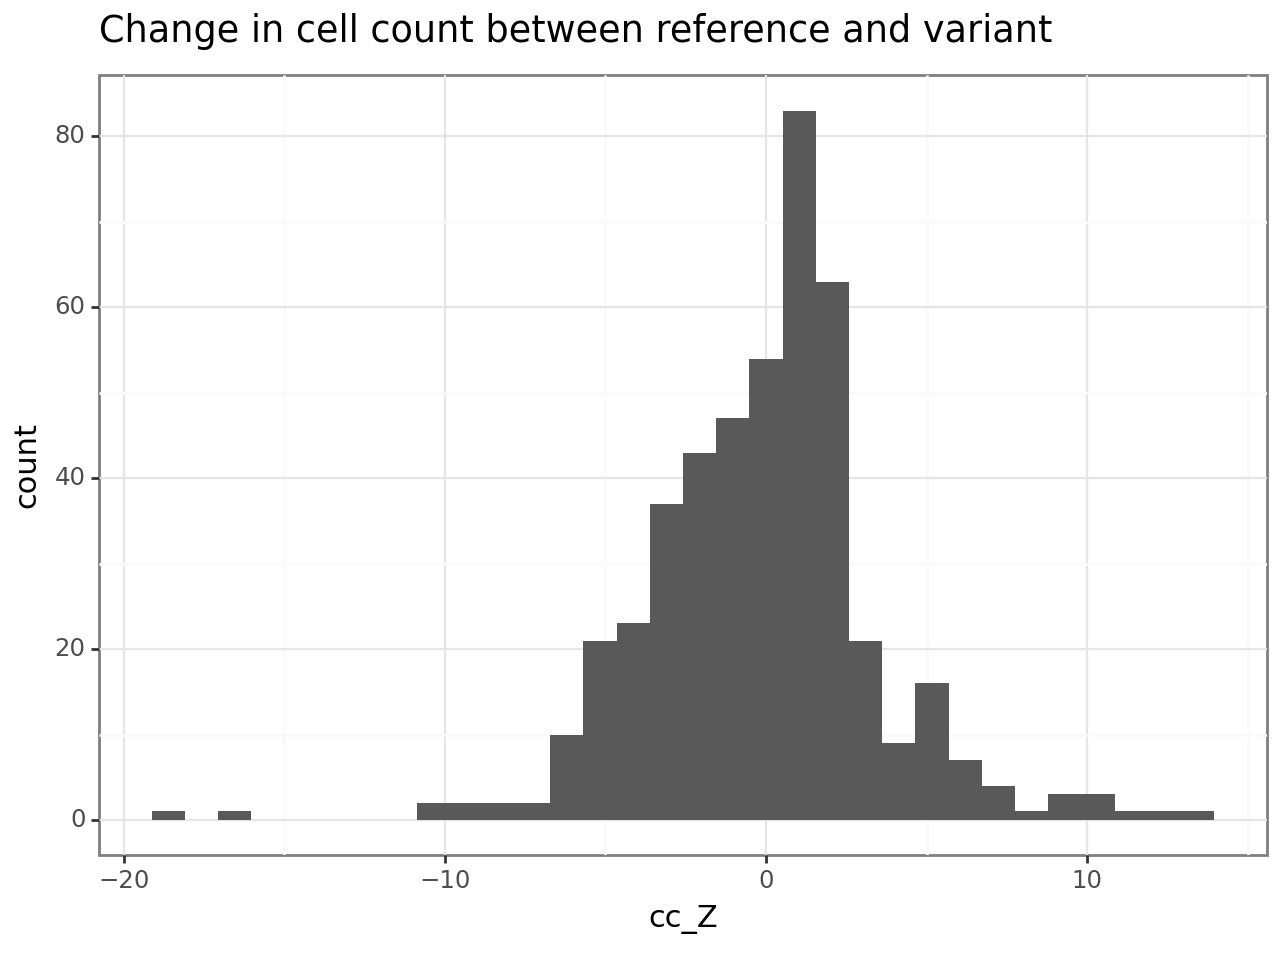

In [14]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs
plot1 = (
    ggplot(
        well_cc_stats,
        aes(x="cc_Z"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in cell count between reference and variant")
)
print(plot1)

### No correction

In [20]:
well_abun_stats_no_corr = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    well_abun_stats_no_corr.append(
        lmm(
            fix_var="Cell_count",
            reference=allele.split("_")[0],
            var=allele,
            dat=temp_prof.to_pandas().dropna(),
            rand_var=None
        )
    )

well_abun_stats_no_corr = pl.concat(well_abun_stats_no_corr, how="vertical")
well_abun_stats_no_corr = well_abun_stats_no_corr.rename({"t": "cc_t"})
well_abun_stats_no_corr.to_pandas().sort_values(by=["P>|t|","Coef."], ascending=[True, False])

## BH multiple test correction
corrected = multipletests(well_abun_stats_no_corr["P>|t|"].to_numpy(), method="fdr_bh")[1]
well_abun_stats_no_corr = well_abun_stats_no_corr.with_columns(pl.Series("FDR", corrected))

  0%|          | 0/458 [00:00<?, ?it/s]/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  1%|          | 3/458 [00:00<00:18, 23.97it/s]/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
/hom

In [23]:
### Write out results
# well_abun_stats_no_corr.write_csv(f"{metrics_dir}/well_cc_changes_no_correction.csv")

# Total number of increase vs. decrease
total = well_abun_stats_no_corr.shape[0]
per_dec = well_abun_stats_no_corr.filter(pl.col("cc_t") < 0).shape[0]/total
per_inc = well_abun_stats_no_corr.filter(pl.col("cc_t") > 0).shape[0]/total

print("total increasing vs. decreasing percent")
print(per_dec)
print(per_inc)

dec_sig = well_abun_stats_no_corr.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_t") < 0).shape[0]
inc_sig = well_abun_stats_no_corr.filter(pl.col("FDR") < 0.05).filter(pl.col("cc_t") > 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

total increasing vs. decreasing percent
0.47161572052401746
0.5283842794759825
Number sig decreases
56
Number sig increases
51


In [40]:
well_abun_stats_no_corr

Coef.,Std.Err.,cc_t,P>|t|,[0.025,0.975],Gene,Variant,FDR
f64,f64,f64,f64,f64,f64,str,str,f64
207.375,60.405752,3.433034,0.004039,77.817547,336.932453,"""MSH2""","""MSH2_Asp167His""",0.024022
-89.125,61.963537,-1.438346,0.172314,-222.023569,43.773569,"""RAD51D""","""RAD51D_Val28Leu""",0.319344
41.125,50.79737,0.809589,0.431722,-67.824522,150.074522,"""RAF1""","""RAF1_Leu613Val""",0.57992
-45.25,49.118434,-0.921243,0.372527,-150.598563,60.098563,"""ZC4H2""","""ZC4H2_Ile7Val""",0.528227
-50.375,74.414905,-0.676948,0.509471,-209.979098,109.229098,"""G6PD""","""G6PD_Arg166Cys""",0.644579
…,…,…,…,…,…,…,…,…
36.875,53.680749,0.686932,0.503346,-78.258755,152.008755,"""RAD51D""","""RAD51D_Ile17Val""",0.641873
-49.0,48.273218,-1.015056,0.327301,-152.535755,54.535755,"""F9""","""F9_Ala397Pro""",0.49802
131.333333,67.274679,1.952196,0.060303,-6.05989,268.726557,"""CCM2""","""CCM2_Gly407Asp""",0.162463


/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


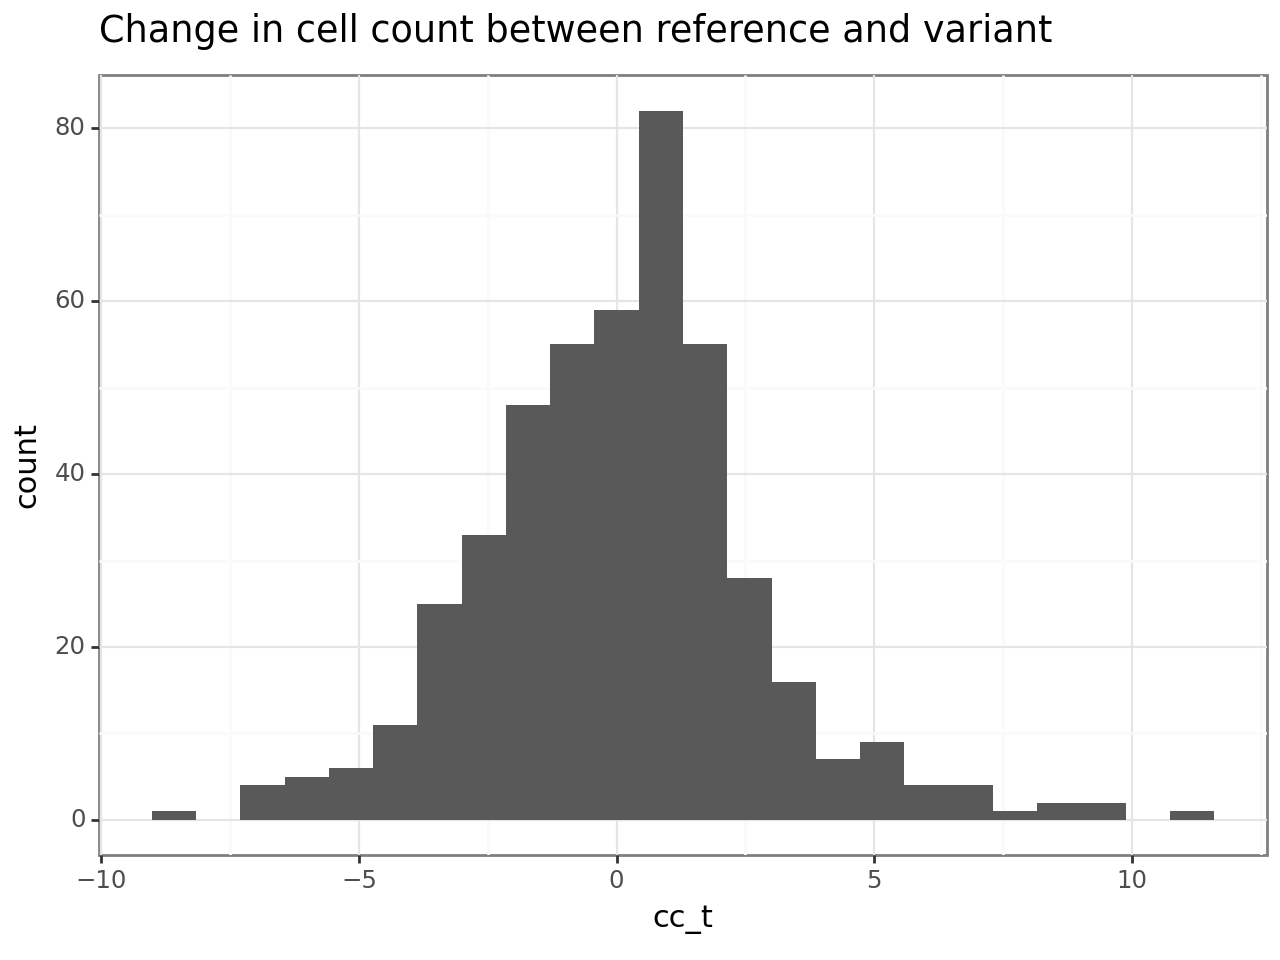

In [22]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs

plot1 = (
    ggplot(
        well_abun_stats_no_corr,
        aes(x="cc_t"),
    )
    + geom_histogram()
    + theme_bw()
    + labs(title="Change in cell count between reference and variant")
)
print(plot1)

### Compare cov. vs no-cov. models

In [60]:
from scipy import stats

def model_selector(fix_var: str, reference: str, var: str, dat, rand_var: str, alpha=0.05):
    """Systematic model selection workflow with diagnostics"""
    # Common formula setup
    formula = f"{fix_var} ~ C(Metadata_gene_allele, Treatment(reference='{reference}')) + C({rand_var})"
    
    # Fit both models
    full_model = smf.ols(
        formula=formula,
        data=dat,
        # groups=dat[rand_var],
        # re_formula="~1"
    ).fit() ## method='powell', reml=False
    
    # reduced_model = smf.ols(formula, dat).fit()

    print(full_model.summary())
    # print(reduced_model.summary())
    # Model comparison metrics
    # comparison = {
    #     "LRT_pvalue": stats.chi2.sf(2*(full_model.llf - reduced_model.llf), df=1),
    #     "AIC_diff": full_model.aic - reduced_model.aic,
    #     "BIC_diff": full_model.bic - reduced_model.bic,
    #     # "var_ratio": full_model.cov_re.iloc[0,0]/full_model.scale,
    #     # "converged": full_model.converged
    # }
    
    # Decision logic
    # if comparison["LRT_pvalue"] < alpha and comparison["var_ratio"] > 0.1:
    #     selected_model = full_model
    #     model_type = "mixedlm"
    # else:
    #     selected_model = reduced_model
    #     model_type = "ols"
    
    # return {
    #     # "selected_model": selected_model,
    #     "model_type": model_type,
    #     "diagnostics": comparison
    # }


# model = model_selector(
#     fix_var="Cell_count",
#     reference=allele.split("_")[0],
#     var=allele,
#     dat=temp_prof.to_pandas().dropna(),
#     rand_var="Metadata_Plate"
# )

2. Rationale & Key Components

* Likelihood Ratio Test (LRT):
    - Compares nested models using chi-square distribution (2Δlog-likelihood ~ χ²)
    - Significant p-value (<α) indicates better fit with random effects
    - Requires ML estimation (reml=False) for valid comparison
* Variance Ratio Check:
    - Calculates random_effect_variance/residual_variance
    - Ratio >0.1 suggests substantial between-group variation needing correction
    - Prevents overfitting trivial random effects
* Information Criteria:
    - AIC/BIC differences help assess model parsimony
    - Negative values favor mixed models despite complexity penalty
* Convergence Check:
    - Ensures mixed model results are reliable
    - Non-converged models should be discarded

In [65]:
well_abun_stats_compare = []
for allele in tqdm(misloc_alleles):
    try:
        temp_class = ind_class.filter(pl.col("allele_0") == allele)
        # display(temp_class)
        temp_prof = profiles.filter(
            (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
            & (
                pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
                | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
            )
        )
        display(temp_prof.to_pandas().dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"]))
        break
        well_abun_stats_compare.append(
            model_selector(
                fix_var="Cell_count",
                reference=allele.split("_")[0],
                var=allele,
                dat=temp_prof.to_pandas().dropna(),
                rand_var="Metadata_Plate"
            )["diagnostics"]
        )
    except:
        continue

  0%|          | 0/461 [00:00<?, ?it/s]

,Metadata_Well,Metadata_Plate,Metadata_gene_allele,Cell_count
4,A01,2025_01_27_B13A7A8P2_T1,RAD51D,399
12,O01,2025_01_27_B13A7A8P2_T1,RAD51D_Ala231Ser,525
6,A01,2025_01_27_B13A7A8P2_T2,RAD51D,390
0,O01,2025_01_27_B13A7A8P2_T2,RAD51D_Ala231Ser,356
5,A01,2025_01_27_B13A7A8P2_T3,RAD51D,532
3,O01,2025_01_27_B13A7A8P2_T3,RAD51D_Ala231Ser,357
14,A01,2025_01_27_B13A7A8P2_T4,RAD51D,426
2,O01,2025_01_27_B13A7A8P2_T4,RAD51D_Ala231Ser,639
9,A01,2025_01_28_B14A7A8P2_T1,RAD51D,313
11,O01,2025_01_28_B14A7A8P2_T1,RAD51D_Ala231Ser,548


  0%|          | 0/461 [00:00<?, ?it/s]


In [54]:
import pandas as pd
well_abun_stats_compare_df = pd.DataFrame(well_abun_stats_compare)

In [57]:
# well_abun_stats_compare_df

KeyError: 'var_ratio'

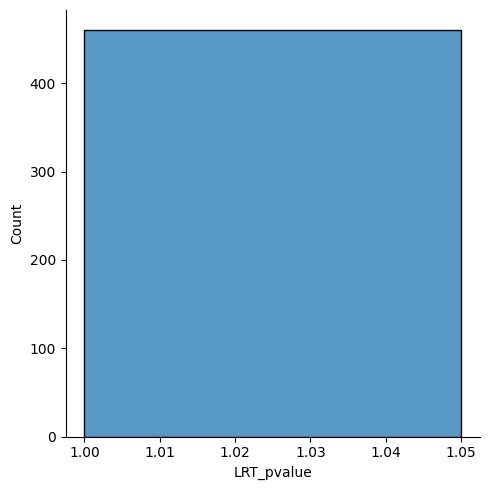

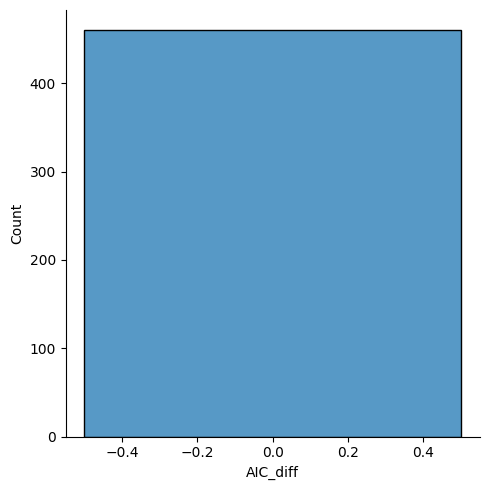

In [56]:
import seaborn as sns
%matplotlib inline

sns.displot(well_abun_stats_compare_df["LRT_pvalue"], binwidth=0.05)
sns.displot(well_abun_stats_compare_df["AIC_diff"])
sns.displot(well_abun_stats_compare_df["var_ratio"], binwidth=0.1)

## Analyze wrt Clinvar Annotations

In [3]:
cc_stats = pl.read_csv("../results/well_cc_changes.csv")

clinvar = pl.read_csv("../data/allele_collection_clinical_significance.csv")
clinvar = clinvar.with_columns(
    pl.concat_str(["symbol", "aa_change"], separator="_").alias("Variant")
).select(["Variant", "clinvar_cs"]).with_columns(
    pl.when(pl.col("clinvar_cs").is_not_null()).then("clinvar_cs").otherwise(pl.lit("not provided")).alias("clinvar_cs")
)

cc_stats = cc_stats.join(clinvar, on="Variant")

/dgx1nas1/storage/data/jess/miniforge3/envs/varchamp/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


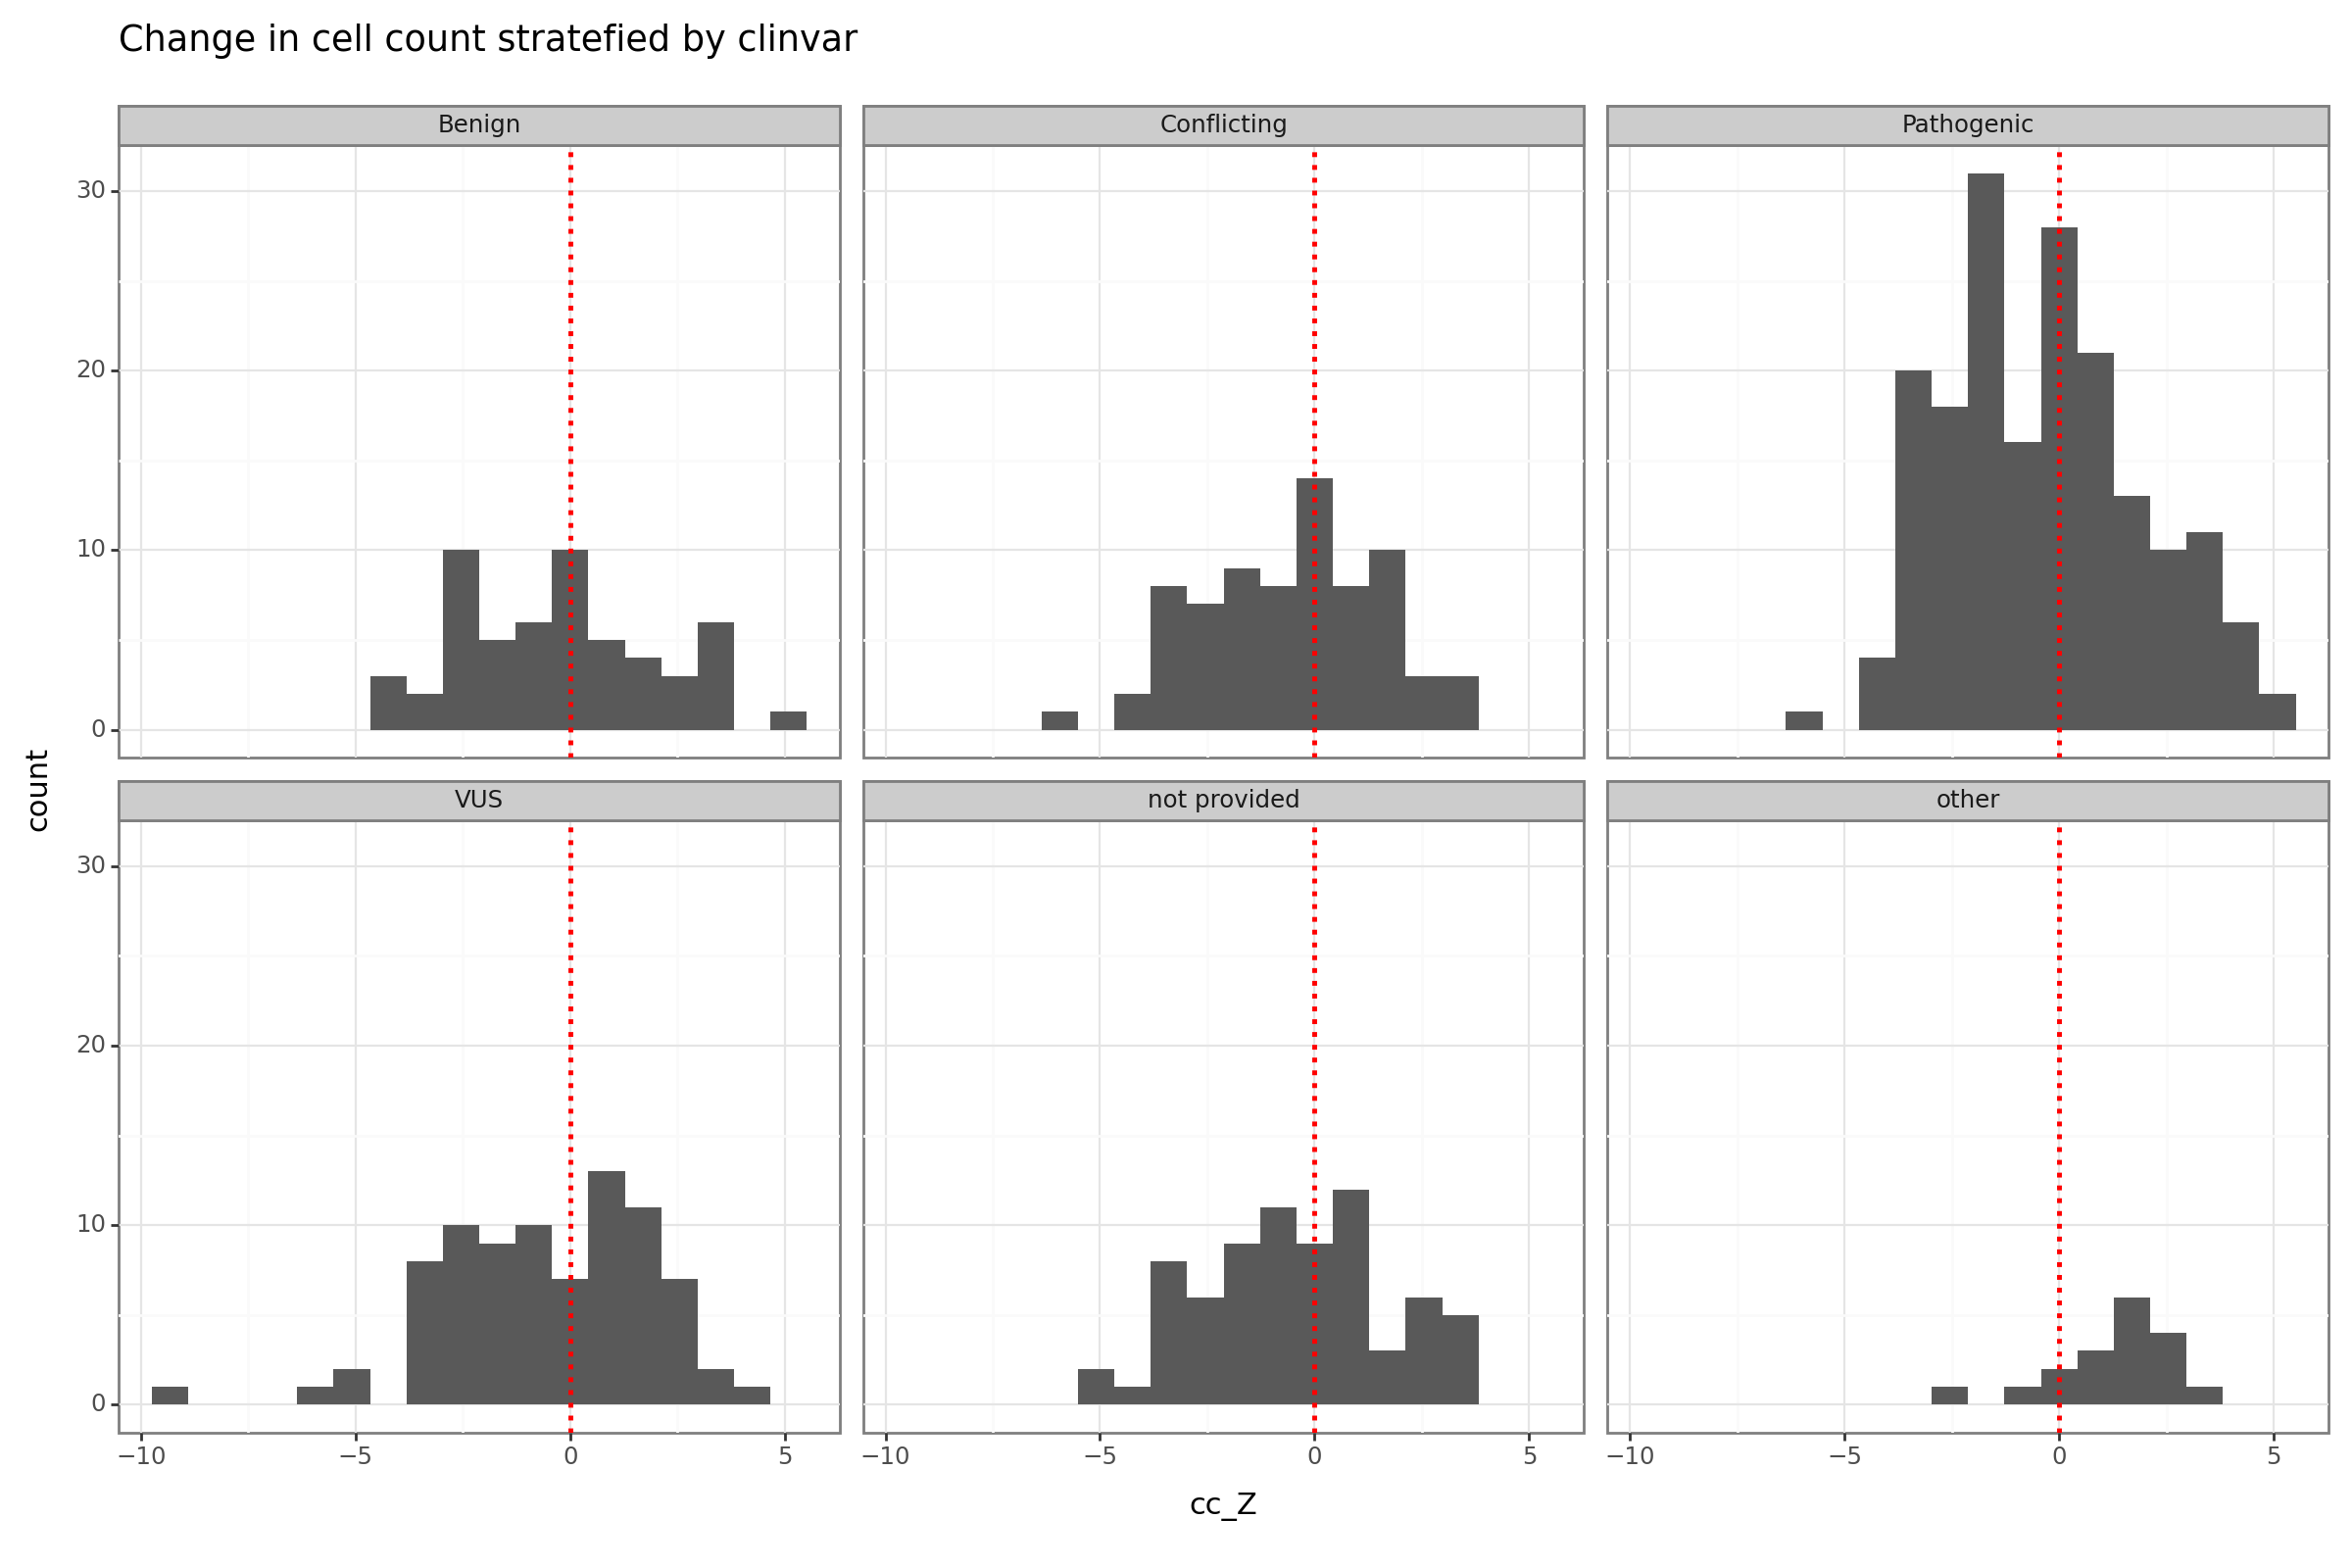

In [6]:
from plotnine import aes, geom_histogram, ggplot, theme_bw, labs, facet_wrap, geom_vline
import plotnine as plotnine

plotnine.options.figure_size = (12, 8)
plot1 = (
    ggplot(
        cc_stats,
        aes(x="cc_Z"),
    )
    + geom_histogram()
    + facet_wrap("clinvar_cs")
    + geom_vline(xintercept=0, color="red", linetype="dotted", size=1)
    + theme_bw()
    + labs(title="Change in cell count stratefied by clinvar")
)
print(plot1)